## Imports

In [2]:
import os
import pathlib
import urllib.request
import tarfile
import pandas as pd
import cv2
import sklearn.model_selection
import sagemaker
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

## Clients

In [3]:
sagemaker_session = sagemaker.Session()

## Constants

In [4]:
BUCKET = "sagemaker-us-east-1-180797159824"
BIRDS_200_DIR = "CUB_200_2011"
BIRDS_200_DATASET_S3_URL = f"https://s3.amazonaws.com/fast-ai-imageclas/{BIRDS_200_DIR}.tgz"
IM2REC_GITHUB_URL = "https://raw.githubusercontent.com/apache/mxnet/master/tools/im2rec.py"

ML_DIR = pathlib.Path("/opt/ml/")
ML_DATA_DIR = ML_DIR / "data"
ML_DATA_BIRDS_200_DIR = ML_DATA_DIR / BIRDS_200_DIR

IMAGE_NAME = "image_name"
IMAGE_ID = "image_id"
CLASS_ID = "class_id"
X_ABS = "x_abs"
Y_ABS = "y_abs"
BBOX_WIDTH = "bbox_width"
BBOX_HEIGHT = "bbox_height"
IMAGE_NAME = "image_name"
IMAGE_HEIGHT = "image_height"
IMAGE_WIDTH = "image_width"
BOX_X0 = "box_x0"
BOX_X1 = "box_x1"
BOX_Y0 = "box_y0"
BOX_Y1 = "box_y1"
OBJECT_WIDTH = "object_width"
EXTRA_HEADER_WIDTH = "extra_header_width"
IS_TRAIN = "is_train"

CLASSES_TXT = ML_DATA_BIRDS_200_DIR / "classes.txt"
BOUNDING_BOX_TXT = ML_DATA_BIRDS_200_DIR / "bounding_boxes.txt"
IMAGES_TXT = ML_DATA_BIRDS_200_DIR / "images.txt"
IMAGE_CLASS_LABELS_TXT = ML_DATA_BIRDS_200_DIR / "image_class_labels.txt"
SIZES_TXT = ML_DATA_BIRDS_200_DIR / "sizes.txt"
TRAIN_TEST_SPLIT_TXT = ML_DATA_BIRDS_200_DIR / "train_test_split.txt"
IMAGES_DIR = ML_DATA_BIRDS_200_DIR / "images"

CLASS_IDS = [17, 36, 47, 68, 73]

RESIZE_SIZE = 256
PACK_LABEL = "bird_200"

TRAIN_LST = f"{PACK_LABEL}_train.lst"
VAL_LST = f"{PACK_LABEL}_val.lst"

TRAIN_REC = f"{PACK_LABEL}_train.rec"
VAL_REC = f"{PACK_LABEL}_val.rec"

TRAIN_CHANNEL = "train"
VALIDATION_CHANNEL = "validation"

LST_COLS = [EXTRA_HEADER_WIDTH, OBJECT_WIDTH, CLASS_ID, BOX_X0, BOX_Y0, BOX_X1, BOX_Y1, IMAGE_NAME]
DO_RANDOM_SAMPLE = True
RANDOM_SAMPLE_TRAIN_FRAC = 0.8

## Create directories

In [5]:
ML_DIR.mkdir(exist_ok=True)
ML_DATA_DIR.mkdir(exist_ok=True)

## Download the dataset

In [6]:
def download(url, download_dir, force=False):
    filename = url.split("/")[-1]
    filepath = download_dir / filename
    if force or not filepath.exists():
        urllib.request.urlretrieve(url, filepath)
    return filepath

In [7]:
dataset_path = download(BIRDS_200_DATASET_S3_URL, download_dir=ML_DATA_DIR)
print(dataset_path)

/opt/ml/data/CUB_200_2011.tgz


## Extract the dataset

In [8]:
compressed = tarfile.open(dataset_path)
compressed.extractall(ML_DATA_DIR)

## Load and Merge the dataset files into one full dataframe

In [9]:
classes_df = pd.read_csv(CLASSES_TXT, sep=" ", names=[CLASS_ID, "class_name"], header=None)
bounding_box_df = pd.read_csv(BOUNDING_BOX_TXT, sep=" ", names=[IMAGE_ID, X_ABS, Y_ABS, BBOX_WIDTH, BBOX_HEIGHT], header=None)
images_df = pd.read_csv(IMAGES_TXT, sep=" ", names=[IMAGE_ID, IMAGE_NAME], header=None)
image_class_labels_df = pd.read_csv(IMAGE_CLASS_LABELS_TXT, sep=" ", names=[IMAGE_ID, CLASS_ID], header=None)
train_test_split_df = pd.read_csv(TRAIN_TEST_SPLIT_TXT, sep=" ", names=[IMAGE_ID, IS_TRAIN], header=None)

full_df = bounding_box_df.merge(images_df, how="outer", on=IMAGE_ID)
full_df = full_df.merge(image_class_labels_df, how="outer", on=IMAGE_ID)
full_df = full_df.merge(train_test_split_df, how="outer", on=IMAGE_ID)
full_df = full_df.merge(classes_df, how="outer", on=CLASS_ID)
if CLASS_IDS:
    full_df = full_df[  full_df[CLASS_ID].isin(CLASS_IDS)  ]

In [10]:
print(f"#rows {len(full_df)}")

#rows 297


#### Add image width, height to the full dataframe

In [11]:
extra_entries = []
for i, row in full_df.iterrows():
    img_path = IMAGES_DIR / row[IMAGE_NAME]
    img = cv2.imread(str(img_path))
    (height, width, _) = img.shape
    entry = {
        IMAGE_HEIGHT: height,
        IMAGE_WIDTH: width,
        IMAGE_ID: row[IMAGE_ID],
    }
    extra_entries.append(entry)

full_df = pd.DataFrame(extra_entries).merge(full_df, how="outer", on=IMAGE_ID)

#### Transform bounding box coordinates to relative coordinates

```
Image coordinates are apparently look like:

(x1, y1) ----------- (x2, y1)
   |                    |
   |                    |
   |                    |
   |                    |
(x1, y2) ----------- (x2, y2)

where x1 < x2, y1 < y2. (0, 0) is in the top-left corner.
```

In [12]:
full_df[BOX_X0] = full_df[X_ABS] / full_df[IMAGE_WIDTH]
full_df[BOX_X1] = (full_df[X_ABS] + full_df[BBOX_WIDTH]) / full_df[IMAGE_WIDTH]
full_df[BOX_Y0] = full_df[Y_ABS] / full_df[IMAGE_HEIGHT]
full_df[BOX_Y1] = (full_df[Y_ABS] + full_df[BBOX_HEIGHT]) / full_df[IMAGE_HEIGHT]

#### Remap classes

In [13]:
class_id_to_new_class_id = dict((k, v) for (v, k) in enumerate(CLASS_IDS))
full_df[CLASS_ID] = full_df[CLASS_ID].map(class_id_to_new_class_id).astype(float)

## Create DataFrame in .lst format

To create annotated .lst files for detection, please refer to the instructions provided in this README - Creating Your Own .lst Files for Detection.
The format of the .lst file is as follows:

```
RowIdx  A  B  [Extra Header]   [(Object0), (Object1), ... (ObjectN)] <Filename>
```

Please note that [Extra Header] and (ObjectX) are separate groups of columns that consist of multiple columns each.

* `RowIdx` indicates the index of the row, starting from 0.
* `A` represents the total number of columns in [Extra Header] plus 2.
* `B` denotes the number of columns that each ObjectX contains.
* `[Extra Header]` is an optional section for additional header information, such as image width/height.
* `[(Object0), (Object1), ..., (ObjectN)]` is a list of objects, where each object is composed of multiple columns.
* `<Filename>` is the relative filepath of the image

The separator `\t` must be used.

In [14]:
def train_test_split(df, train_frac):
    (train_rows, val_rows) = ([], [])
    for _, row in df.iterrows():
        split_rows = train_rows if random.random() < train_frac else val_rows
        split_rows.append(row)
    return (pd.DataFrame(train_rows), pd.DataFrame(val_rows))

In [15]:
full_df[EXTRA_HEADER_WIDTH] = 2
full_df[OBJECT_WIDTH] = 5

lst_df = full_df.reset_index()

if DO_RANDOM_SAMPLE:
    (train_df, val_df) = train_test_split(lst_df, train_frac=RANDOM_SAMPLE_TRAIN_FRAC)
else:
    is_train_criteria = lst_df[IS_TRAIN] == 0
    (train_df, val_df) = (lst_df[is_train_criteria], lst_df[~is_train_criteria])

train_df[LST_COLS].to_csv(TRAIN_LST, sep="\t", float_format="%.4f", header=False)
val_df[LST_COLS].to_csv(VAL_LST, sep="\t", float_format="%.4f", header=False)

## Sanity Checks

#### Make sure the column ordering is correct.

```
[index, A, B, zero-based-class-id, x0, y0, x1, y1, relative-file-path]
```

In [16]:
!head -n 10 $TRAIN_LST

0	2	5	0.0000	0.3960	0.2054	0.8640	0.9643	017.Cardinal/Cardinal_0038_19203.jpg
1	2	5	0.0000	0.1700	0.0428	0.8380	0.9118	017.Cardinal/Cardinal_0072_17159.jpg
2	2	5	0.0000	0.2360	0.0569	0.9440	0.9281	017.Cardinal/Cardinal_0085_19162.jpg
3	2	5	0.0000	0.2840	0.1231	0.6160	0.8945	017.Cardinal/Cardinal_0047_17673.jpg
4	2	5	0.0000	0.2260	0.1034	0.8480	0.6351	017.Cardinal/Cardinal_0094_17165.jpg
5	2	5	0.0000	0.2549	0.3380	0.5978	0.6840	017.Cardinal/Cardinal_0035_17678.jpg
6	2	5	0.0000	0.4175	0.1460	0.9025	0.9540	017.Cardinal/Cardinal_0045_18021.jpg
7	2	5	0.0000	0.0040	0.0660	0.9380	0.9835	017.Cardinal/Cardinal_0103_17425.jpg
8	2	5	0.0000	0.4380	0.0587	0.9780	0.9973	017.Cardinal/Cardinal_0102_17808.jpg
9	2	5	0.0000	0.3280	0.2319	0.9740	0.9274	017.Cardinal/Cardinal_0006_17684.jpg


In [17]:
!head -n 10 $VAL_LST

10	2	5	0.0000	0.1494	0.1540	0.8759	0.8840	017.Cardinal/Cardinal_0054_19334.jpg
12	2	5	0.0000	0.2620	0.0671	0.8800	0.8952	017.Cardinal/Cardinal_0078_17181.jpg
20	2	5	0.0000	0.2500	0.2673	0.9980	0.9760	017.Cardinal/Cardinal_0019_17368.jpg
22	2	5	0.0000	0.2400	0.1243	0.9800	0.8757	017.Cardinal/Cardinal_0025_17239.jpg
25	2	5	0.0000	0.2760	0.2949	0.8360	0.7923	017.Cardinal/Cardinal_0105_19045.jpg
28	2	5	0.0000	0.2649	0.1400	0.7518	0.6760	017.Cardinal/Cardinal_0050_18035.jpg
35	2	5	0.0000	0.0740	0.2727	0.7880	0.8091	017.Cardinal/Cardinal_0052_18334.jpg
37	2	5	0.0000	0.3840	0.0931	0.7940	0.9429	017.Cardinal/Cardinal_0074_18339.jpg
38	2	5	0.0000	0.1380	0.3667	0.5880	0.8215	017.Cardinal/Cardinal_0084_17576.jpg
41	2	5	0.0000	0.1960	0.0027	0.8940	0.9547	017.Cardinal/Cardinal_0056_18352.jpg


#### Plot a few bounding boxes, just to be safe

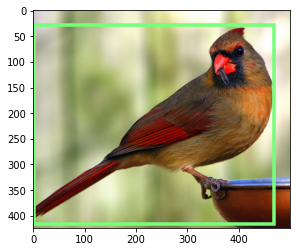

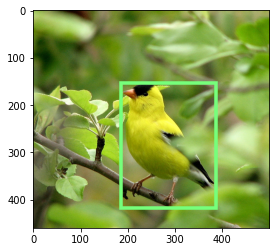

In [18]:
%matplotlib inline


def show(row):
    image_name = row["image_name"]
    x0 = row["box_x0"]
    x1 = row["box_x1"]
    y0 = row["box_y0"]
    y1 = row["box_y1"]
    
    img_path = IMAGES_DIR / image_name
    img = mpimg.imread(img_path)
    height = img.shape[0]
    width = img.shape[1]
    xmin = int(x0 * width)
    ymin = int(y0 * height)
    xmax = int(x1 * width)
    ymax = int(y1 * height)
    rect = plt.Rectangle(
        (xmin, ymin),
        xmax - xmin,
        ymax - ymin,
        fill=False,
        linewidth=3.5,
        color="#76FF7B",
    )
    plt.gca().add_patch(rect)
    plt.imshow(img)
    plt.show()


show(train_df.iloc[random.randint(0, len(train_df) - 1)])
show(val_df.iloc[random.randint(0, len(val_df) - 1)])

## Create RecordIO files -- model inputs

The model expects RecordIO files as input. This is accomplished by [im2rec.py](https://github.com/apache/mxnet/blob/master/tools/im2rec.py) as follows:
Download and run the `im2rec.py` to produce the .rec file

In [19]:
download(IM2REC_GITHUB_URL, download_dir=pathlib.Path("."))
os.system(f"python3 im2rec.py --resize {RESIZE_SIZE} --pack-label {PACK_LABEL} {IMAGES_DIR}")

0

## Upload and Register RecordIO files

In [20]:
sagemaker_session.upload_data(path=TRAIN_REC, bucket=BUCKET, key_prefix=TRAIN_CHANNEL)
sagemaker_session.upload_data(path=VAL_REC, bucket=BUCKET, key_prefix=VALIDATION_CHANNEL)

's3://sagemaker-us-east-1-180797159824/validation/bird_200_val.rec'

## Some Stats to Facilitate Training Model

In [21]:
print(f"num-train={len(train_df)}, num-val={len(val_df)}, num-classes={len(CLASS_IDS)}")

num-train=226, num-val=71, num-classes=5


The files are now in s3, ready to use for training.